In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from colorama import Style

№1. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [2]:
def msbfs_levels(A, start_vertices):
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")
        
    n = A.nrows
    m = start_vertices.size
    result = Matrix(dtypes.INT32, m, n)
    f = Matrix(bool, m, n)
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i, start_vertices[i]] << True 
    
    level = 0
    while True:
        result(mask=f.V) << level
        f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
        for i in range(m):
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False) 
            
        finish_flg = True
        for i in range(m):
            if succ[i]:
                finish_flg = False
                break
                
        if finish_flg:
            break
            
        level += 1    
    
    res = result.to_dense(fill_value=-1)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
        
    return output

№2. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [3]:
def msbfs_parents(A, start_vertices):
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")

    N = A.nrows
    M = start_vertices.size

    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:, j] << j

    parents = Matrix(dtypes.INT64, M, N)
    wavefront = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        parents[i, start_vertices[i]] << start_vertices[i] 
        wavefront[i, start_vertices[i]] << 1
        
    while wavefront.nvals > 0:
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        parents(binary.plus) << wavefront 
    
    for ind in range(len(start_vertices)):
        parents[ind, start_vertices[ind]] << -1
    
    res = parents.to_dense(fill_value=-2)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
    
    return output

№3. Добавить тесты для проверки корректности полученных реализаций.

Всего будет 3 графа для проверки:
* неориентированный граф (проверка того, что отработает ошибка);
* граф со связанными вершинами (но не обязательно достижимы из каждой стартовой точки);
* граф, у которого вершины сгруппированы в "островки".

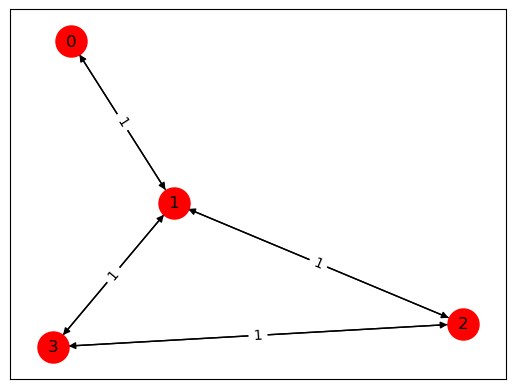

In [4]:
matrix1 = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0]
])
M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

gb.viz.draw(M1)

In [5]:
try:
    msbfs_levels(M1, np.array([0, 1, 2, 3]))
except Exception as e:
    if str(e) == "Error!!! Граф неориентированный!":
        print("msbfs_levels: Тест пройден")
    else:
        print(f"msbfs_levels: Неверное сообщение об ошибке: {e}")
else:
    print("msbfs_levels: Исключение не было вызвано")

msbfs_levels: Тест пройден


In [6]:
try:
    msbfs_parents(M1, np.array([0, 1, 2, 3]))
except Exception as e:
    if str(e) == "Error!!! Граф неориентированный!":
        print("msbfs_parents: Тест пройден")
    else:
        print(f"msbfs_parents: Неверное сообщение об ошибке: {e}")
else:
    print("msbfs_parents: Исключение не было вызвано")

msbfs_parents: Тест пройден


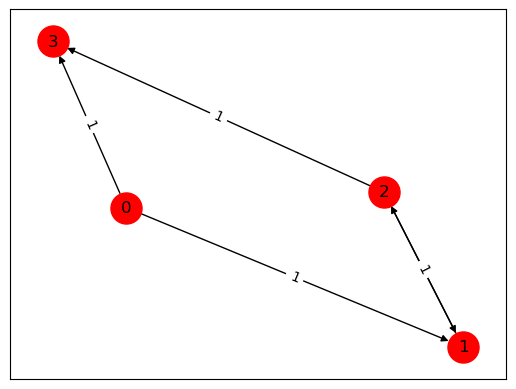

In [7]:
matrix2 = np.array([
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 0]
])
M2 = gb.Matrix.from_dense(matrix2, missing_value=0)

gb.viz.draw(M2)

assert (msbfs_levels(M2, np.array([0, 1, 3]))[0]==np.array([0, 1, 2, 1])).all()
assert (msbfs_levels(M2, np.array([0, 1, 3]))[1]==np.array([-1, 0, 1, 2])).all()
assert (msbfs_levels(M2, np.array([0, 1, 3]))[3]==np.array([-1, -1, -1, 0])).all()

assert (msbfs_parents(M2, np.array([0, 1, 3]))[0]==np.array([-1, 0, 1, 0])).all()
assert (msbfs_parents(M2, np.array([0, 1, 3]))[1]==np.array([-2, -1, 1, 2])).all()
assert (msbfs_parents(M2, np.array([0, 1, 3]))[3]==np.array([-2, -2, -2, -1])).all()

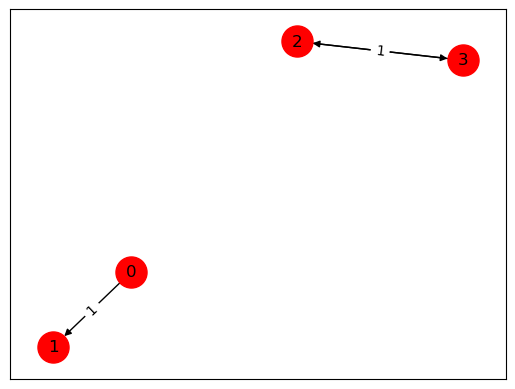

In [8]:
matrix3 = np.array([
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
M3 = gb.Matrix.from_dense(matrix3, missing_value=0)

gb.viz.draw(M3)

assert (msbfs_levels(M3, np.array([3, 2, 1]))[3]==np.array([-1, -1, 1, 0])).all()
assert (msbfs_levels(M3, np.array([3, 2, 1]))[2]==np.array([-1, -1, 0, 1])).all()
assert (msbfs_levels(M3, np.array([3, 2, 1]))[1]==np.array([-1, 0, -1, -1])).all()

assert (msbfs_parents(M3, np.array([3, 2, 1]))[3]==np.array([-2, -2, 3, -1])).all()
assert (msbfs_parents(M3, np.array([3, 2, 1]))[2]==np.array([-2, -2, -1, 2])).all()
assert (msbfs_parents(M3, np.array([3, 2, 1]))[1]==np.array([-2, -1, -2, -2])).all()

№4.(+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

In [9]:
'''Функции для тестирования'''

def gen_vertices(num_vertices, vertex_frac):
    '''
    генерация стартовых вершин в зависимости от числа вершин (num_vertices) и 
    доли (в %) стартовых вершин от общего числа (vertex_frac)
    '''
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)

def test(A, start_vertices):
    print('msbfs_levels:')
    %timeit msbfs_levels(A, start_vertices)
    print()
    print('msbfs_parents:')
    %timeit msbfs_parents(A, start_vertices)
    print('\n')

**Тестирование на графах с SuiteSparse Matrix Collection**

In [10]:
graph_names = [
    'Roget.mtx',
    'CSphd.mtx',
    'GD06_Java.mtx'
]

vertex_fracs=[5, 35, 70, 95] # доли стартовых вершин от общего числа

In [11]:
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(graph_name)
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для Roget.mtx.mtx (Количество вершин: 1022, количество ребер: 5075), степень разреженности: 0.0049
Количество стартовых вершин: 51
msbfs_levels:
95.3 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
82.6 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 357
msbfs_levels:
672 ms ± 64.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
170 ms ± 823 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 715
msbfs_levels:
1.14 s ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
262 ms ± 8.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 970
msbfs_levels:
1.62 s ± 79.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents:
338 ms ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Для CSphd.mtx.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности

**Тестирование на случайно сгенерированных графах**

In [12]:
def generate_graph(num_vertices, num_edges):
    positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    gen_indices = random.sample(positions, num_edges)
    
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    
    return gb.Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)

In [13]:
# Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
19.8 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
14.4 ms ± 57.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
41.8 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
33.1 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
75.8 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
96.9 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels:
180 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
373 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loo

In [14]:
# Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
msbfs_levels:
96.8 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
82.8 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
msbfs_levels:
92.4 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
105 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
msbfs_levels:
97 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
133 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
msbfs_levels:
95.9 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
115 ms ± 6.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops e

In [15]:
# Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
msbfs_levels:
43.4 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
85.7 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
msbfs_levels:
79.1 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
116 ms ± 5.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
msbfs_levels:
118 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
157 ms ± 4.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
msbfs_levels:
152 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents:
197 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loo

**Выводы**

* С ростом числа вершин (при степени разреженности = 0.5 и числе стартовых вершин = 50%) увеличивается время работы обоих алгоритмов. Это связано с тем, что увеличивается количество столбцов матриц, что влечет к усложнению произведения матричного умножения. Стоит отметить, что зависимость времени для алгоритма msbfs_levels от числа вершин примерно линейная, в то время как для второго алгоритма зависимость уже является степенной.

* При увеличении числа стартовых вершин (при фиксированном числе вершин = 500 и степени разреженности = 50%) также можно отметить увеличение времени работы алгоритмов, в обоих случаях зависимость близка к линейной. Это объясняется всё тем же "удорожанием" матричного умножения, т.к. увеличение числа стартовых вершин напрямую сказывается на строковой размерности фронта.

* При увеличении степени разреженности (при уплотнении графа) какой-то явной зависимости выявлено не было. Более того, по результатам тестов получилось так, что алгоритмы работают быстрее на графах со средней степенью разреженности. В целом, это можно назвать логичным, поскольку алгоритмы адаптируются под реальные графы, а на практике очень редко можно встретить практически полные или совсем разреженные графы.

* Что касается сравнения время работы алгоритмов друг с другом, то тут можно сказать следующее: с увеличением размеров графа msbfs_parents всё более явно начинает дольше работать, нежели msbfs_levels.

№5. (+3 балла) Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

Все, что меняется в функциях, это то, что изменяется полукольцо в параметре semiring на any_pair и any_first.

In [16]:
def msbfs_levels_anypair(A, start_vertices):
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")
        
    n = A.nrows
    m = start_vertices.size
    result = Matrix(dtypes.INT32, m, n)
    f = Matrix(bool, m, n)
    succ = Vector(bool, m)
    
    for i in range(m):
        f[i, start_vertices[i]] << True 
    
    level = 0
    while True:
        result(mask=f.V) << level 
        f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)
        for i in range(m):
            succ[i] << f[i, :].reduce(monoid.lor, allow_empty=False) 
            
        finish_flg = True
        for i in range(m):
            if succ[i]:
                finish_flg = False
                break
                
        if finish_flg:
            break
            
        level += 1    
        
    res = result.to_dense(fill_value=-1)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
        
    return output

In [17]:
def msbfs_parents_anyfirst(A, start_vertices):
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")

    N = A.nrows
    M = start_vertices.size

    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:, j] << j
        
    parents = Matrix(dtypes.INT64, M, N)
    wavefront = Matrix(dtypes.UINT64, M, N)
    
    for i in range(M):
        parents[i, start_vertices[i]] << start_vertices[i]
        wavefront[i, start_vertices[i]] << 1
        
    while wavefront.nvals > 0:
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
        parents(binary.plus) << wavefront 
    
    for ind in range(len(start_vertices)):
        parents[ind, start_vertices[ind]] << -1
    
    res = parents.to_dense(fill_value=-2)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
    
    return output

**Проверка корректности** (берем прошлые тесты)

In [18]:
try:
    msbfs_levels_anypair(M1, np.array([0, 1, 2, 3]))
except Exception as e:
    if str(e) == "Error!!! Граф неориентированный!":
        print("msbfs_levels_anypair: Тест пройден")
    else:
        print(f"msbfs_levels_anypair: Неверное сообщение об ошибке: {e}")
else:
    print("msbfs_levels_anypair: Исключение не было вызвано")

msbfs_levels_anypair: Тест пройден


In [19]:
try:
    msbfs_parents_anyfirst(M1, np.array([0, 1, 2, 3]))
except Exception as e:
    if str(e) == "Error!!! Граф неориентированный!":
        print("msbfs_parents_anyfirst: Тест пройден")
    else:
        print(f"msbfs_parents_anyfirst: Неверное сообщение об ошибке: {e}")
else:
    print("msbfs_parents_anyfirst: Исключение не было вызвано")

msbfs_parents_anyfirst: Тест пройден


In [20]:
assert (msbfs_levels_anypair(M2, np.array([0, 1, 3]))[0]==np.array([0, 1, 2, 1])).all()
assert (msbfs_levels_anypair(M2, np.array([0, 1, 3]))[1]==np.array([-1, 0, 1, 2])).all()
assert (msbfs_levels_anypair(M2, np.array([0, 1, 3]))[3]==np.array([-1, -1, -1, 0])).all()

assert (msbfs_parents_anyfirst(M2, np.array([0, 1, 3]))[0]==np.array([-1, 0, 1, 0])).all()
assert (msbfs_parents_anyfirst(M2, np.array([0, 1, 3]))[1]==np.array([-2, -1, 1, 2])).all()
assert (msbfs_parents_anyfirst(M2, np.array([0, 1, 3]))[3]==np.array([-2, -2, -2, -1])).all()

In [21]:
assert (msbfs_levels_anypair(M3, np.array([3, 2, 1]))[3]==np.array([-1, -1, 1, 0])).all()
assert (msbfs_levels_anypair(M3, np.array([3, 2, 1]))[2]==np.array([-1, -1, 0, 1])).all()
assert (msbfs_levels_anypair(M3, np.array([3, 2, 1]))[1]==np.array([-1, 0, -1, -1])).all()

assert (msbfs_parents_anyfirst(M3, np.array([3, 2, 1]))[3]==np.array([-2, -2, 3, -1])).all()
assert (msbfs_parents_anyfirst(M3, np.array([3, 2, 1]))[2]==np.array([-2, -2, -1, 2])).all()
assert (msbfs_parents_anyfirst(M3, np.array([3, 2, 1]))[1]==np.array([-2, -1, -2, -2])).all()

In [22]:
# Тестирование
def test_any(A, start_vertices):
    print('msbfs_levels_anypair:')
    %timeit msbfs_levels_anypair(A, start_vertices)
    print()
    print('msbfs_parents_anyfirst:')
    %timeit msbfs_parents_anyfirst(A, start_vertices)
    print('\n')

**Тестирование на тех же графах с SuiteSparse Matrix Collection**

In [23]:
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(graph_name)
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_any(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для Roget.mtx.mtx (Количество вершин: 1022, количество ребер: 5075), степень разреженности: 0.0049
Количество стартовых вершин: 51
msbfs_levels_anypair:
79.4 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
83.6 ms ± 4.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 357
msbfs_levels_anypair:
590 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
190 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 715
msbfs_levels_anypair:
1.33 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
262 ms ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 970
msbfs_levels_anypair:
1.59 s ± 65.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

msbfs_parents_anyfirst:
364 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Для CSphd.mtx.mtx (Колич

**Тестирование на случайно сгенерированных графах**

In [24]:
# Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_any(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
20.6 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
14.2 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
46.9 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
36.2 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
76.4 ms ± 390 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
83.7 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
msbfs_levels_anypair:
179 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyf

In [25]:
# Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_any(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
msbfs_levels_anypair:
97.6 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
79.9 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
msbfs_levels_anypair:
95.8 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
91.8 ms ± 5.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
msbfs_levels_anypair:
99.5 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
120 ms ± 4.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
msbfs_levels_anypair:
94.9 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_an

In [ ]:
# Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test_any(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
msbfs_levels_anypair:
49 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:
77.2 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
msbfs_levels_anypair:
81.4 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

msbfs_parents_anyfirst:


**Выводы**

При сравнении алгоритмов с различными полукольцами можно сделать вывод о том, что в целом время отработки алгоритмов практически не изменилось в среднем, хотя в крайних случаях (небольшие графы / очень разреженные / очень плотные/ небольшое число стартовых вершин) работает лучше.